In [ ]:
#!pip install tensorflow keras split-folders opencv-python
#!pip install split-folders

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-06-01 20:09:40.622265: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 20:09:40.625286: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 20:09:40.633009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748819380.645321   34118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748819380.649187   34118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748819380.660004   34118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Executar essa cédula pra conectar o Colab ao Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
input_folder = "bloodcells_dataset_reduced"
output_folder = "image_recognition"

In [4]:
split_ratio = (0.8, 0.1, 0.1)
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=split_ratio,
    group_prefix=None
)   # Cria as pastas test, train e val no image_recognition


Copying files: 4000 files [00:00, 10419.46 files/s]


In [5]:
# Define the parameters
img_size = (360, 360)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,    # resnet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_dir = os.path.join(output_folder, 'train')
test_dir = os.path.join(output_folder, 'test')
valid_dir = os.path.join(output_folder, 'val')

In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Evita inconsistência na predição
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [9]:
# Get a batch of images and labels
images, labels = next(valid_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.779..131.32].


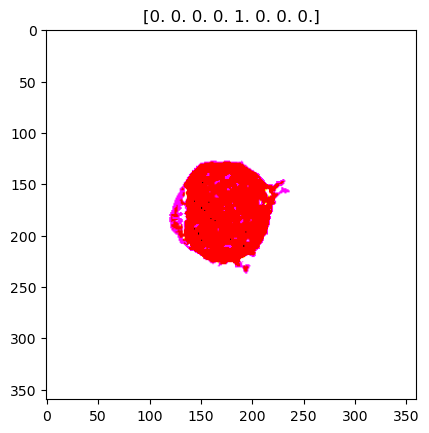

In [13]:
# Select a random image from the batch
idx =  random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

In [14]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

2025-06-01 20:10:41.155540: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

In [ ]:
# Rodar apenas se tiver o treinamento já carregado
# model.load_weights('/content/drive/MyDrive/IA/bloodcells_image_recognition/CropModel.keras')

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Rodar apenas ao treinar o algoritmo
model.fit(train_data, epochs=10, validation_data=valid_data)

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.3014 - loss: 1.8661 - val_accuracy: 0.6175 - val_loss: 1.0851
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.5908 - loss: 1.1277 - val_accuracy: 0.7500 - val_loss: 0.7775
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.6795 - loss: 0.9078 - val_accuracy: 0.7775 - val_loss: 0.6081
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7255 - loss: 0.7931 - val_accuracy: 0.7825 - val_loss: 0.5757
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7643 - loss: 0.6963 - val_accuracy: 0.7925 - val_loss: 0.5379
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.7821 - loss: 0.6465 - val_accuracy: 0.7975 - val_loss: 0.5166
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.8031 - loss: 0.5852 - val_accuracy: 0.8300 - val_loss: 0.4509
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8157 - loss: 0.5714 - val_accu

In [19]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8984 - loss: 0.3575
Test accuracy: 88.75%
Test loss: 36.74%


In [20]:
class_names = {0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3:'ig', 4:'lymphocyte',
               5:'monocyte', 6:'neutrophil', 7:'platelet'}

In [21]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img, img_size)
    test_img=np.expand_dims(test_img, axis=0)
    result=model.predict(test_img)
    r=np.argmax(result)
    print(class_names[r])

In [22]:
predict_img('image_recognition/train/ig/MMY_21284.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
ig


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


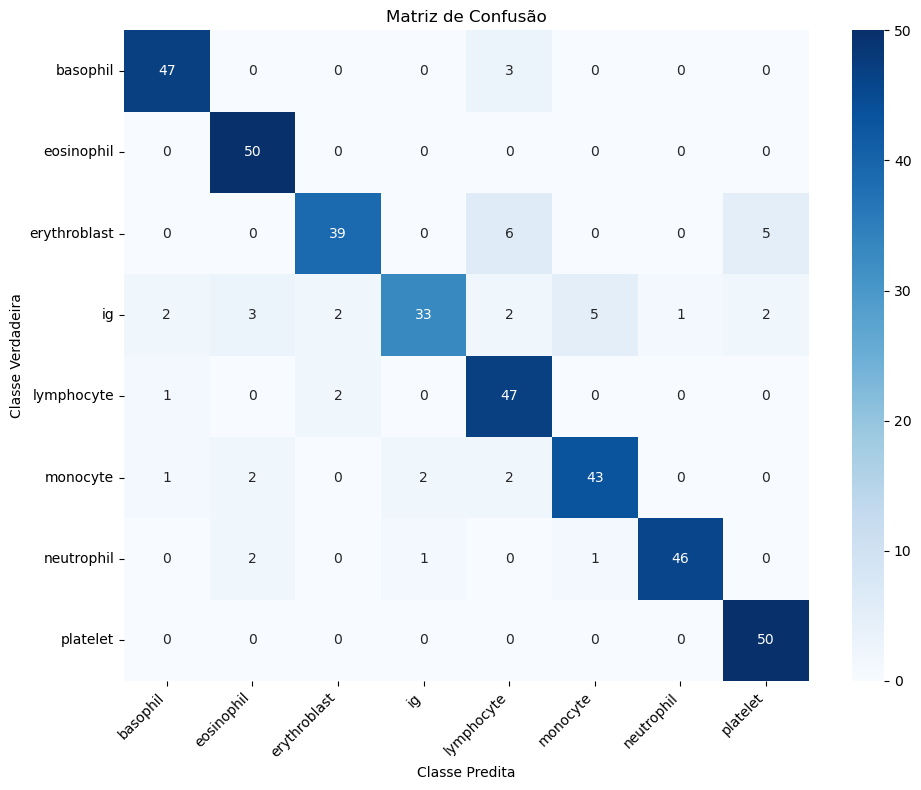


Relatório de Classificação:
              precision    recall  f1-score   support

    basophil       0.92      0.94      0.93        50
  eosinophil       0.88      1.00      0.93        50
erythroblast       0.91      0.78      0.84        50
          ig       0.92      0.66      0.77        50
  lymphocyte       0.78      0.94      0.85        50
    monocyte       0.88      0.86      0.87        50
  neutrophil       0.98      0.92      0.95        50
    platelet       0.88      1.00      0.93        50

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.88       400
weighted avg       0.89      0.89      0.88       400



In [23]:
# Certifique-se de que o modelo está carregado ou treinado antes de executar esta célula.
# Se você não treinou o modelo na sessão atual e está apenas carregando os pesos,
# verifique se a célula model.load_weights() foi executada sem erros.

# 1. Fazer previsões no conjunto de teste
# O número de passos deve cobrir todo o conjunto de teste
num_test_samples = test_data.samples
# Se test_data.batch_size foi alterado para predição, use esse valor, senão use o batch_size original
# Para garantir, podemos recalcular batch_size aqui se necessário ou usar o global

# Y_pred_probs conterá as probabilidades para cada classe
Y_pred_probs = model.predict(test_data, steps=int(np.ceil(num_test_samples / test_data.batch_size)))

# Y_pred conterá a classe predita (o índice da classe com maior probabilidade)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# 2. Obter os rótulos verdadeiros
# Como definimos shuffle=False para test_data, test_data.classes nos dará os rótulos na ordem correta
Y_true = test_data.classes

# 3. Obter os nomes das classes para o plot
# Precisamos deles como uma lista na ordem dos índices para o heatmap
target_names = [class_names[i] for i in range(len(class_names))]

# 4. Calcular a matriz de confusão
cm = confusion_matrix(Y_true, Y_pred)

# 5. Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

# 6. (Opcional) Exibir o relatório de classificação para mais métricas (precisão, recall, f1-score)
print("\nRelatório de Classificação:")
print(classification_report(Y_true, Y_pred, target_names=target_names))

In [26]:
# Necessário rodar essa célula para salvar os pesos do treinamento
model.save('CropModel.keras')